In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%bash
mkdir -p "/content/gdrive/My Drive/development/ai/2-mario-ai-dqn/video"

**Pre-reading material:**

Deep Q Network:
1. https://www.intel.ai/demystifying-deep-reinforcement-learning/
1. https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c 
1. https://pylessons.com/CartPole-DDQN/

> Note: Article #2 has an error: `target = self.target_model.predict(state)` 
>
> should be: `target = self.model.predict(state)`

**Important notes I noticed while training:**

From link #5:
1. https://towardsdatascience.com/from-zero-to-flagpole-hero-ead14fc46fba

> With everything setup, I ran the same code I used for the Atari games but instead targeted the first level of Super Mario Bros. and… nothing happened. I waited an hour, but Mario only figured out that he gets killed by the first Goomba in the level, and he generally doesn’t like getting killed, so a better tactic is to just stand in place and safely wait for time to expire.

From link #6: 
1. https://web.archive.org/web/20190630025508/https://www.statworx.com/de/blog/using-reinforcement-learning-to-play-super-mario-bros-on-nes-using-tensorflow/

About 10,000 episodes and 20 hours of compute on Google Cloud was needed to learn the first level!



In [0]:
%%bash
pip3 install gym
pip3 install gym-super-mario-bros
pip3 install keras==2.3.1
pip3 install matplotlib
apt-get update
apt-get -y install ffmpeg
apt-get -y install libsm6 libxext6

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the new

**OpenAI's Gym toolkit documentation:**

http://gym.openai.com/docs/#observations


In [0]:
# VIDEO_MONITOR_DIR = "/content/gdrive/My Drive/development/ai/2-mario-ai-dqn/video/"
VIDEO_MONITOR_DIR = "/content/video/"
STATE_SAVE_DIR = "/content/gdrive/My Drive/development/ai/2-mario-ai-dqn"

# how many states/steps to keep in memory for training sampling
MEMORY_CAPACITY = 20000
# number of steps to fill memory before starting to train
BURN_IN_STEPS = 5000
# how many frames (previous + last one) to keep in history per state
# a few frames are needed in order for the network to understand movement/motion
FRAME_SKIP_STACK_SIZE = 4
# how many states to use per training iteration
TRAIN_BATCH_SIZE = 32
# how many steps to wait until updating target model
TARGET_UPDATE_FREQUENCY = 500
# epsilon settings for DQN
EPSILON_START = .99
EPSILON_START = .01
EPSILON_MIN = .05
EPSILON_DECAY = 0.99995
# gradient descent!
LEARNING_RATE = 1e-4

# during frame capture, we will resize frame down to 84x84 pixels
SHAPE_SIZE = (84, 84, 1)

Lets setup the environment to play Super Mario Bros! We will import the gym_super_mario_bros library to run our game.

The video recording (gym.wrappers.Monitor) lib requires the close() call to flush the video data onto disk, but close() causes issues with the mario env to not be rerunnable. Lets fix that:

In [0]:
import cv2
import gym
from gym import Wrapper
from gym.spaces import Box
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
from nes_py.wrappers import JoypadSpace
import numpy as np

class NoCloseFix(Wrapper):
  # allow create_env to be rerunnable. monitor needs close to write mp4 file...
  def close(self):
    self.env.reset()


Original NES video frames are 240x256 RGB pixels. We can downscale to reduce the amount of inputs our network needs and still provide accurate results! Lets also remove color information since that isn't needed to beat the game.

In [0]:
class CustomViewport(Wrapper):
  def __init__(self, env=None):
    super(CustomViewport, self).__init__(env)
    # nes resolution: (240 vertical, 256 horizontal, 3 rgb)
    self.observation_space = Box(low=0, high=1, shape=(240, 256, 1))
    self.observation_space = Box(low=0, high=1, shape=SHAPE_SIZE)

  def step(self, action):
    state, reward, done, info = self.env.step(action)
    state = self.process_frame(state)
    return state, reward, done, info
  
  # process_frame for monitoring video
  def render(self, mode):
    state = self.env.render(mode)
    state = self.process_frame(state)
    # convert grayscale back to 3 channel rgb:
    # ([1,2],)*2 = ([1, 2], [1, 2])
    state = np.stack((state,)*3, axis=-1)
    return (state * 255).astype(np.uint8)

  def reset(self):
    return self.process_frame(self.env.reset())
  
  def process_frame(self, frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (SHAPE_SIZE[0], SHAPE_SIZE[1]), interpolation=cv2.INTER_AREA)
    return frame / 255.0


A single frame is not enough to take action upon. We need to whether we are moving to make a decision and that requires a few frames:

In [0]:
class CustomSkipFrame(Wrapper):
  def __init__(self, env, skip=4):
    super(CustomSkipFrame, self).__init__(env)
    self.observation_space = Box(low=0, high=1, shape=(SHAPE_SIZE[0], SHAPE_SIZE[1], FRAME_SKIP_STACK_SIZE))
    self.skip = skip

  def step(self, action):
    total_reward = 0.0
    state, reward, done, info = self.env.step(action)
    state = state.reshape(state.shape[0], state.shape[1], 1) #60x64x1
    states = state

    for i in range(self.skip - 1):
      if not done:
        state, reward, done, info = self.env.step(action)
        state = state.reshape(state.shape[0], state.shape[1], 1) #60x64x1
        total_reward += reward
        states = np.append(state, states[:, :, :], axis=2)
      else:
        total_reward += reward
        states = np.append(state, states[:, :, :], axis=2)
    
    return states.astype(np.float32), total_reward, done, info

  def reset(self):
      state = self.env.reset()
      states = np.stack((state,)*FRAME_SKIP_STACK_SIZE, axis=-1)
      return states


The gym-super-mario-bros has its own reward function:

https://github.com/Kautenja/gym-super-mario-bros#reward-function

We will add some more incentives to the environment:

In [0]:
class CustomReward(Wrapper):
  def __init__(self, env=None):
    super(CustomReward, self).__init__(env)
    self._current_score = 0

  def step(self, action):
    state, reward, done, info = self.env.step(action)
    reward += (info['score'] - self._current_score) / 40.0
    self._current_score = info['score']
    if done:
      if info['flag_get']:
        reward += 350.0
      else:
        reward -= 50.0
    return state, reward / 10.0, done, info


Lets combine all the previous wrappers to produce a usable environment for our AI model:

In [0]:
def create_env():
  world = 1
  stage = 1
  env = gym_super_mario_bros.make("SuperMarioBros-{}-{}-v0".format(world, stage))
  
  # lets allow our environment to have full movement
  actions = COMPLEX_MOVEMENT
  env = JoypadSpace(env, actions)

  print(env.observation_space.shape)
  env = NoCloseFix(env)
  env = gym.wrappers.Monitor(env, VIDEO_MONITOR_DIR, video_callable=lambda episode_id: True, force = False)
  env = CustomViewport(env)
  env = CustomSkipFrame(env)
  env = CustomReward(env)

  return env


Now we start defining the real model that learns how to play mario:

In [0]:
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import Adam

from collections import deque
import random

class DQN:
  def dummy(self):
    pass


Using TensorFlow backend.


In [0]:
class DQN(DQN):

  def __init__(self, env):
    self.env = env
    self.memory = deque(maxlen=MEMORY_CAPACITY)
    
    self.epsilon = EPSILON_START
    self.epsilon_min = EPSILON_MIN
    self.epsilon_decay = EPSILON_DECAY
    self.learning_rate = LEARNING_RATE
    self.gamma = 0.85
    self.tau = .125
    self.step_count = 1
    self.target_update_frequency = TARGET_UPDATE_FREQUENCY

    self.model = self.create_model()
    self.target_model = self.create_model()


The is the actual neural network that predicts how much total reward will be produced based off the current input video frames. Output is the reward per possible action (left, right, up, down, etc...):

In [0]:
from keras.models import load_model

class DQN(DQN):

  def create_model(self):
    input_shape = self.env.observation_space.shape
    input_shape = (input_shape[0], input_shape[1], FRAME_SKIP_STACK_SIZE)

    model = Sequential()
    model.add(Conv2D(32, 8, strides=4, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, 4, strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, 3, strides=1, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(self.env.action_space.n))

    model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
    return model
  
  def save_model(self, fn):
    self.model.save(fn)

  def load_model(self, fn):
    self.model = load_model(fn)
    target_weights = self.model.get_weights()
    self.target_model.set_weights(target_weights)

In the early stages of the agent's lifetime, the agent hasnt experienced/learned about rewards for each possible action. The epsilon variable forces the agent to choose a random action. Over time the value of epsilon decreases to allow the agent to make its own decisions when it has enough training:

In [0]:
class DQN(DQN):
  
  def act_train(self, state):
    self.epsilon *= self.epsilon_decay
    self.epsilon = max(self.epsilon_min, self.epsilon)
    if np.random.random() < self.epsilon:
      # print("random action: %f" % (self.epsilon))
      return self.env.action_space.sample()
    return np.argmax(self.model.predict(state)[0])
  
  def act_test(self, state):
    return np.argmax(self.target_model.predict(state)[0])

As we progress through the environment, we will memorize the actions we have taken and the reward we received. We use that to define the error function for the neural network.

Make note that the target value is not just the immediate reward for the current action, but a prediction of what will be rewarded for future possible actions.

In [0]:
class DQN(DQN):
  
  def memorize(self, state, action, reward, new_state, done):
    self.memory.append([state, action, reward, new_state, done])
    self.step_count += 1
  
  def replay(self):
    if self.step_count < BURN_IN_STEPS:
      return
    if len(self.memory) < TRAIN_BATCH_SIZE: 
      return
    
    samples = random.sample(self.memory, TRAIN_BATCH_SIZE)
    batch_state = np.zeros((TRAIN_BATCH_SIZE, SHAPE_SIZE[0], SHAPE_SIZE[1], FRAME_SKIP_STACK_SIZE))
    batch_new_state = np.zeros((TRAIN_BATCH_SIZE, SHAPE_SIZE[0], SHAPE_SIZE[1], FRAME_SKIP_STACK_SIZE))
    
    for i in range(TRAIN_BATCH_SIZE):
      state, action, reward, new_state, done = samples[i]
      batch_state[i] = state
      batch_new_state[i] = new_state
    
    # do batch prediction to save speed
    # predict Q-values for starting state using the main network
    target = self.model.predict(batch_state)
    Q_future = self.target_model.predict(batch_new_state)
    
    for i in range(TRAIN_BATCH_SIZE):
      state, action, reward, new_state, done = samples[i]
      # target = self.model.predict(state)
      if done:
        target[i][action] = reward
      else:
        # Q_future = max(self.target_model.predict(new_state)[0])
        target[i][action] = reward + max(Q_future[i]) * self.gamma
    
    self.model.fit(batch_state, target, batch_size=TRAIN_BATCH_SIZE, epochs=1, verbose=0)
    
  def target_train(self):
    if self.step_count < BURN_IN_STEPS:
      return
    if (self.step_count - BURN_IN_STEPS) % self.target_update_frequency == 0:
      print("Updating training weights...")
      weights = self.model.get_weights()
      target_weights = self.target_model.get_weights()
      for i in range(len(target_weights)):
        target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
      self.target_model.set_weights(target_weights)

Here is the code that actually runs the environment and the model together. It will take time to train...

In [0]:
import keras
import gc
import json

import matplotlib.pyplot as plt
from IPython import display

def model_load(dqn_agent):
  print("Loading existing model...")
  dqn_agent.load_model(STATE_SAVE_DIR + "/mario-ai.h5")
  with open(STATE_SAVE_DIR + "/mario-ai.json") as f:
    model_info = json.load(f)
  return model_info

def model_save(dqn_agent, info):
  print("Saving state...")
  dqn_agent.save_model(STATE_SAVE_DIR + "/mario-ai.h5")
  with open(STATE_SAVE_DIR + "/mario-ai.json", "w") as f:
    f.write(json.dumps(info))

def run_episode(env, dqn_agent, run_info, train, episode, total_step):
  episode_reward = 0.0
  stage_step = 0

  # http://gym.openai.com/docs/#observations
  # state = np.ndarray = image data for game
  state = env.reset()
  # In Keras, need to reshape to add an extra dimension for number of samples: (num_samples, w, h, channels)
  state = state.reshape(1, state.shape[0], state.shape[1], state.shape[2])  #1*80*80*4

  while (True):
    if train:
      action = dqn_agent.act_train(state)
    else:
      action = dqn_agent.act_test(state)
    
    new_state, reward, done, info = env.step(action)
    new_state = new_state.reshape(1, new_state.shape[0], new_state.shape[1], new_state.shape[2])  #1*80*80*4
    episode_reward += reward

    if stage_step % 50 == 0:
      # print("[Time=%3d][Steps={total:%d|episode:%d|stage:%d}][x=%d][y=%d][Reward={total:%f|step:%f}][action=%s][epsilon=%f]" 
      #   % (info["time"], total_step, episode, stage_step, info["x_pos"], info["y_pos"], episode_reward, reward, COMPLEX_MOVEMENT[action], dqn_agent.epsilon))
      print("[Time=%3d][Steps={total:%d|episode:%d|stage:%d}][x=%d][y=%d][Reward={total:%f|step:%f}][epsilon=%f]" 
        % (info["time"], total_step, episode, stage_step, info["x_pos"], info["y_pos"], episode_reward, reward, dqn_agent.epsilon))

    if train:
      dqn_agent.memorize(state, action, reward, new_state, done)
      dqn_agent.replay() # internally iterates default (prediction) model
      dqn_agent.target_train() # iterates target model

      if total_step > BURN_IN_STEPS and (total_step - BURN_IN_STEPS + 1) % 5000 == 0:
        model_save(dqn_agent, run_info)
    
    state = new_state
    total_step += 1
    stage_step += 1

    if done:
      break
  
  return stage_step, episode_reward, info["x_pos"]

def main(env, load, train):
  info = {}
  info["hist_reward"] = []
  info["hist_x_pos"] = []
  info["hist_episode"] = []
  print(env.observation_space.shape)

  dqn_agent = DQN(env=env)
  total_step = 0
  episode = 0

  if load:
    info = model_load(dqn_agent)
    episode = max(info["hist_episode"]) + 1

  while (True):
    stage_step, reward, x_pos = run_episode(env, dqn_agent, info, train, episode, total_step)
    print('[Episode=%d][Reward=%f][x=%d]' % (episode, reward, x_pos))

    if total_step > BURN_IN_STEPS:
      info["hist_reward"].append(reward)
      info["hist_x_pos"].append(int(x_pos))
      info["hist_episode"].append(int(episode))

      display.clear_output(wait=True)
      display.display(plt.gcf())
      plt.clf()
      fig, (ax1, ax2) = plt.subplots(2)
      ax1.plot(info["hist_episode"], info["hist_x_pos"])
      ax2.plot(info["hist_episode"], info["hist_reward"])
      plt.show()

      episode += 1
    
    total_step += stage_step

  del dqn_agent

Lets clean up any left over video files from a previous run:

In [0]:
import shutil
# clean up video folder before each run!
shutil.rmtree(VIDEO_MONITOR_DIR)

Now we start training!:

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

try:
  env = create_env()
  main(env, load=False, train=True)
finally:
  env.close()
  keras.backend.clear_session()
  gc.collect()

After training, we can run a test against our model:

In [0]:
try:
  env = create_env()
  main(env, load=True, train=False)
finally:
  env.close()
  keras.backend.clear_session()
  gc.collect()

Here is the results of our training on about 12000 episodes:

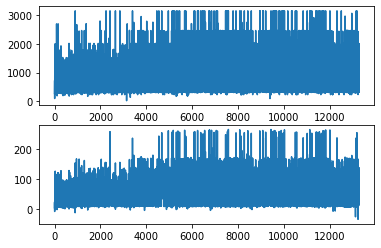

In [0]:
with open(STATE_SAVE_DIR + "/mario-ai.json") as f:
  info = json.load(f)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(info["hist_episode"], info["hist_x_pos"])
ax2.plot(info["hist_episode"], info["hist_reward"])
plt.show()

Video of DQN agent completing the first level: [link](https://drive.google.com/file/d/1B0pc3Hfj1DneOXxMNPJyKLvCDg7nVWN3/view?usp=sharing)